<a href="https://colab.research.google.com/github/kiyong21c/Must_Have_pytorch_DL/blob/main/20220915_UNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 배경과 동물의 픽셀을 분리
 - 알고리즘 : U-Net
 - 문제유형 : 분류
 - 평가지표 : BCE 오차

 - 합성곱 → 업샘플링
  > 합성곱 : 커널을 이용해 특징을 추출

  > 업샘플링 : 커널을 이용해 특징으로부터 이미지 복원(복원된 특징은 합성곱을 통해 추출된 특징과 합쳐짐)

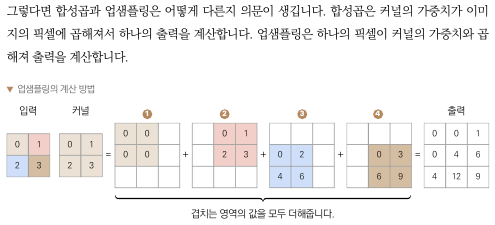

## 데이터 살펴보기
 - Oxford-IIIT Pet 데이터셋
 - 고양이와 강아지 이미지 약 7,000장
 - 원본RGB 이미지와 배경,경계,동물 픽셀을 구분하는 정답이미지가 한쌍으로 제공

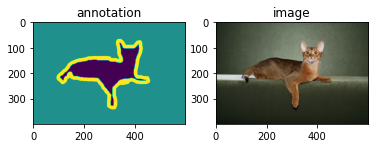

In [3]:
# 입력과 정답 이미지 확인하기
import matplotlib.pyplot as plt
from PIL import Image

path_to_annotation = '/content/drive/MyDrive/Colab Notebooks/data/CH07/CH07/annotations/trimaps/'
path_to_image = '/content/drive/MyDrive/Colab Notebooks/data/CH07/CH07/images/'

# 이미지 불러오기
annotation = Image.open(path_to_annotation + 'Abyssinian_1.png')
plt.subplot(1, 2, 1)
plt.title('annotation')
plt.imshow(annotation);

image = Image.open(path_to_image + 'Abyssinian_1.jpg')
plt.subplot(1, 2, 2)
plt.title('image')
plt.imshow(image);

<Figure size 720x1440 with 0 Axes>

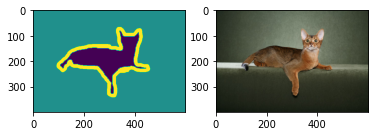

In [ ]:
# subplots를 활용하는 방법
plt.figure(figsize=(10, 20))
fig, ax = plt.subplots(1, 2)
for idx, i in enumerate([annotation, image]):
    ax[idx].imshow(i)

## 학습용 데이터 만들기
 - 데이터셋을 학습에 이용할 수 있게 Dataset객체를 이용해 표현해야 함
 - 1.  데이터셋 초기화 함수 구현

 - 2. 학습난이도 낮추기 위해 정답을 약간 수정

  > 기존 : 동물=0, 동물과 배경의 경계=1, 배경=2

  > 수정 : 배경=0, 동물 및 경계=1

  > 이진분류가 다중분류보다 간단하므로

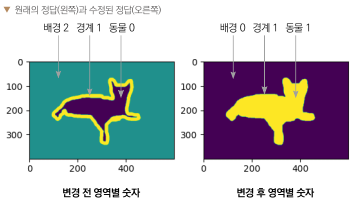

In [5]:
# 데이터셋 만들기
import glob # 파일들의 리스트를 뽑을 때 사용
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

from torch.utils.data.dataset import Dataset
from PIL import Image

# Dataset클래스를 이용해 데이터셋 클래스 만들때 "굳이" 상속필요 없다.
class Pets(Dataset):
    def __init__(self,
                 path_to_img,
                 path_to_anno,
                 train=True,            # 향후 Dataset 정의할때 train=True/False에 따라 다른 데이터를 return하기 위함
                 transforms=None,
                 input_size=(128, 128)):
        
        # 정답과 입력 이미지를 이름순으로 정렬
        self.images = sorted(glob.glob(path_to_img+'/*.jpg'))   # 이미지경로를 알파벳 순으로 정렬한 리스트
        self.annotations = sorted(glob.glob(path_to_anno+'/*.png'))
        
        # # 각각의 리스트가 아니라 합쳐서 DataFrame으로 만들자
        # self.dataframe = pd.DataFrame(zip(self.images, self.annotations), columns=['images','annotations'])
        # # 데이터셋을 학습과 평가용으로 나눔(나눠서 정의하고 __len__, __getitem__에서 다르게 return할 예정)
        # self.X_train, self.X_test, self.Y_train, self.Y_test = train_test_split(self.dataframe['images'],
        #                                                                         self.dataframe['annotations'],
        #                                                                         test_size=0.2)
        
        # 데이터셋을 학습과 평가용으로 나눔
        self.X_train = self.images[:int(0.8 * len(self.images))]
        self.X_test = self.images[int(0.8 * len(self.images)):]
        self.Y_train = self.annotations[:int(0.8 * len(self.annotations))]
        self.Y_test = self.annotations[int(0.8 * len(self.annotations)):]



        # 파라미터 설정
        self.train = train # True : __len__정의할때 조건문에 사용예정
        self.transforms = transforms # None
        self.input_size = input_size # (128, 128)

    # 데이터의 개수를 반환하는 함수
    def __len__(self):
        if self.train:  # True
            return len(self.X_train)
        else:
            return len(self.X_test)

    # Pets클래스 내에서 __getitem__메소드에서 사용될 함수를 만듦
    def preprocess_mask(self, mask):    # mask : "정답이미지객체"를 입력할 예정
        mask = mask.resize(self.input_size)
        mask = np.array(mask).astype(np.float32) # np.array(이미지객체) : PIL이미지 → numpy배열화
        mask[mask == 2.0] = 0.0 # 배경(2.0) → 0으로 변환
        mask[mask != 2.0] = 1.0 # 경계(1.0),동물(0.0) → 1로 변환
        mask = torch.tensor(mask) # torch.tensor(array배열) : array → tensor (새로운 메모리 할당)
        # torch.from_numpy(mask) →위와 결과는 동일하나 기존 메모리 상속받음
        return mask
    
    # 데이터를 불러오는 함수
    def __getitem__(self, i):
        # 학습용 데이터로 설정한 경우
        if self.train:  # True
            X_train = Image.open(self.X_train[i]) # PIL이미지객체
            X_train = self.transforms(X_train)  # Pets클래스 정의할 때 transforms파라미터에 알맞는 함수가 들어갈 예정
            Y_train = Image.open(self.Y_train[i]) # PIL이미지객체
            Y_train = self.preprocess_mask(Y_train) # 함수로 정의한 preprocess_mask에 PIL이미지객체 입력 → tensor 반환

            return X_train, Y_train # i인덱스에 해당하는 학습용 데이터 반환

        # 평가용 데이터로 설정한 경우
        else:
            X_test = Image.open(self.X_test[i]) # PIL이미지객체
            X_test = self.transforms(X_test)  # Pets클래스 정의할 때 transforms파라미터에 알맞는 함수가 들어갈 예정
            Y_test = Image.open(self.Y_test[i]) # PIL이미지객체
            Y_test = self.preprocess_mask(Y_test) # 함수로 정의한 preprocess_mask에 PIL이미지객체 입력 → tensor 반환

            return X_test, Y_test

## U-Net 모델 정의하기
 - 인코더 : Conv2D()함수를 이용 → 특징 추출
 - 디코더 : Convtranspose2D()함수를 이용 → 업샘플링
 - 최종 출력은 0과 1사이의 값을 갖는 1채널 이미지

  > squeeze()함수를 이용해 채널 차원을 제거해줌

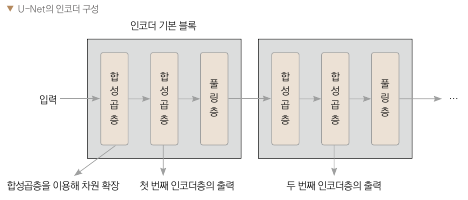

 - 기본블록 구성 : 합성곱층 X 2 + 풀링층
 - 향후 디코더에서 인코더의 출력을 사용하므로, 인코더 기본블록의 출력 저장(enc_1_1, enc2_2 등)

  > enc_1_1 : 인코더 첫번째 블록의 첫번째 합성곱 결과

In [6]:
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # UNet 인코더에 사용되는 은닉층
        # 기본블록1
        self.enc1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1) # 채널 3 → 64
        self.enc1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1) # 채널 3 → 64
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # 가로세로 사이즈 1/2
        # 기본블록2
        self.enc2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # 채널 64 → 128
        self.enc2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1) # 채널 128 → 128
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # 가로세로 사이즈 1/2
        # 기본블록3
        self.enc3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1) # 채널 128 → 256
        self.enc3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1) # 채널 256 → 256
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # 가로세로 사이즈 1/2
        # 기본블록4
        self.enc4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1) # 채널 256 → 512
        self.enc4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1) # 채널 512 → 512
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2) # 가로세로 사이즈 1/2
        # 인코더 마지막 기본블록
        self.enc5_1 = nn.Conv2d(512, 1024, kernel_size=3, padding=1) # 채널 512 → 1024
        self.enc5_2 = nn.Conv2d(1024, 512, kernel_size=3, padding=1) # 채널 1024 → 512

        # 디코더에 사용되는 은닉층
        self.upsample4 = nn.ConvTranspose2d(512, 512, 2, stride=2) # 인코더 기본블록5의 self.enc5_2가 입력으로 사용됨
        self.dec4_1 = nn.Conv2d(1024, 512, kernel_size=3, padding=1) # 채널 1024 → 512
        self.dec4_2 = nn.Conv2d(512, 256, kernel_size=3, padding=1) # 채널 512 → 256

        self.upsample3 = nn.ConvTranspose2d(256, 256, 2, stride=2) # 인코더 기본블록3의 self.enc3_2가 입력으로 사용됨
        self.dec3_1 = nn.Conv2d(512, 256, kernel_size=3, padding=1) # 채널 512 → 256
        self.dec3_2 = nn.Conv2d(256, 128, kernel_size=3, padding=1) # 채널 256 → 128

        self.upsample2 = nn.ConvTranspose2d(128, 128, 2, stride=2) # 인코더 기본블록2의 self.enc2_2가 입력으로 사용됨
        self.dec3_1 = nn.Conv2d(512, 256, kernel_size=3, padding=1) # 채널 512 → 256
        self.dec3_2 = nn.Conv2d(256, 128, kernel_size=3, padding=1) # 채널 256 → 128
        
        self.upsample1 = nn.ConvTranspose2d(64, 64, 2, stride=2) # 인코더 기본블록1의 self.enc1_2가 입력으로 사용됨
        self.dec3_1 = nn.Conv2d(128, 64, kernel_size=3, padding=1) # 채널 128 → 64
        self.dec3_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1) # 채널 64 → 64
        self.dec3_3 = nn.Conv2d(64, 1, kernel_size=3) # 채널 64 → 1 : 모든 픽셀이 0과1 사이값 → 시그 모이드 함수 → 0 또는 1이 됨

        # 합성곱과 업샘플링층의 활성화 함수
        self.relu = nn.ReLU()

    def forward(self, x):
        # 인코더의 순전파 정의
        x = self.enc1_1(x)
        x = self.relu(x)
        e1 = self.enc1_2(x) # 디코더에서 사용하기 위해 따로 변수 지정
        e1 = self.relu(e1)  # 디코더에 사용하기 위한 인코더의 출력은 풀링 하지 않음
        x = self.pool1(e1)

        x = self.enc2_1(x)
        x = self.relu(x)
        e2 = self.enc2_2(x) # 디코더에서 사용하기 위해 따로 변수 지정
        e2 = self.relu(e2)  # 디코더에 사용하기 위한 인코더의 출력은 풀링 하지 않음
        x = self.pool2(e2)

        x = self.enc3_1(x)
        x = self.relu(x)
        e3 = self.enc3_2(x) # 디코더에서 사용하기 위해 따로 변수 지정
        e3 = self.relu(e3)  # 디코더에 사용하기 위한 인코더의 출력은 풀링 하지 않음
        x = self.pool3(e3)

        x = self.enc4_1(x)
        x = self.relu(x)
        e4 = self.enc4_2(x) # 디코더에서 사용하기 위해 따로 변수 지정
        e4 = self.relu(e4)  # 디코더에 사용하기 위한 인코더의 출력은 풀링 하지 않음 → [512, 16, 16]
        x = self.pool4(e4)

        x = self.enc5_1(x)
        x = self.relu(x)
        x = self.enc5_2(x) # 디코더에서 사용되지 않음
        x = self.relu(x) # → [512, 8, 8]
    
        # 디코더의 순전파 정의
        x = self.upsample4(x) # x : 512channel 채널의 변화는 없으며, size 가로/세로 2배 증가 → [512, 16, 16]

        # 인코더의 출력과 업샘플링된 이미지의 채널을 합침
        x = torch.cat([x, e4], dim=0) # 채널의 차원이 인덱스1번째 : 채널차원을 옆으로 붙이는 것 같은 효과
        # x는 enc5_2가 업샘플링되어 [512, 16, 16], e4는 enc4_2를 풀링하지 않고 변수를 별도로 지정한 [512, 16, 16]
        # torch.cat → [1024, 16, 16] # 채널차원 합쳐짐(채널을 붙임)
        x = self.dec4_1(x) # [512, 16, 16]
        x = x.relu(x)
        x = x.self.dec4_2(x) # [256, 16, 16]
        x = self.relu(x)

        x = self.upsample3(x) # [256, 32, 32]
        x = torch.cat([x, e3], dim=0) # [512, 32, 32]
        x = self.dec3_1(x) # [256, 32, 32]
        x = self.relu(x)
        x = self.dec3_2(x) # [128, 32, 32]
        x = self.relu(x)
        
        x = self.upsample2(x) # [128, 64, 64]
        x = torch.cat([x, e2], dim=0) # [256, 64, 64]
        x = self.dec2_1(x) # [128, 64, 64]
        x = self.relu(x)
        x = self.dec2_2(x) # [64, 64, 64]
        x = self.relu(x)

        x = self.upsample1(x) # [64, 128, 128]
        x = torch.cat([x, e1], dim=0) # [128, 128, 128]
        x = self.dec1_1(x) # [64, 128, 128]
        x = self.relu(x)
        x = self.dec1_2(x) # [64, 128, 128] 
        x = self.relu(x)
        x = self.dec1_3(x) # [1, 128, 128]

        x = torch.squeeze(x) # 흑백 이미지(2차원)를 위해 채널차원을 없앰 → [128, 128]

        return x # [128, 128]

In [7]:
import torch
a = torch.zeros((512, 16, 16))
b = torch.zeros((512, 16, 16))

c = torch.cat([a, b], dim=0) # 채널차원을 합침
c.shape

torch.Size([1024, 16, 16])

In [8]:
import torch.nn as nn

upsample = nn.ConvTranspose2d(512, 512, 2, 2)
upsample(a).shape # 업샘플링시 채널 수의 변화 없음, 가로/세로 크기만 2배

torch.Size([512, 32, 32])

In [9]:
dec = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
dec(c).shape

torch.Size([512, 16, 16])

In [10]:
e = torch.zeros((1, 128, 128))
torch.squeeze(e).shape

torch.Size([128, 128])

## 모델 학습 하기
 - 손실함수 : BCEWithLogitsLoss()
 - BCE : Binary Cross Entropy 이진분류에 사용하는 CE(크로스 엔트로피)
 - 사용이유 : 모델이 출력하는 이미지의 출력값이 모두 0(배경)이거나 1(동물)이기 때문

 - 내부적으로 시그모이드 연산이 들어가있음

  > 신경망정의할때, __init__/forward 등에서 활성화 하지 않아도 됨

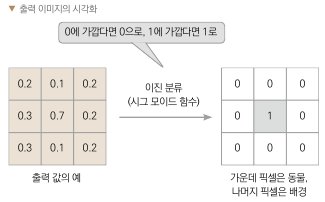

In [11]:
# 데이터 전처리
import tqdm

from torchvision.transforms import Compose
from torchvision.transforms import ToTensor, Resize
from torch.optim.adam import Adam
from torch.utils.data.dataloader import DataLoader

device = 'cuda' if torch.cuda.is_available() else 'cpu'

transform = Compose([Resize((128, 128)),    # Pets클래스 정의할때 입력으로 128x128 크기의 이미지를 받기로 하였음
                     ToTensor()])

In [12]:
# 학습용 데이터
train_set = Pets(path_to_img=path_to_image,
                 path_to_anno=path_to_annotation,
                 transforms=transform,
                 train=True)

# 평가용 데이터
test_set = Pets(path_to_img=path_to_image,
                path_to_anno=path_to_annotation,
                transforms=transform,
                train=False)

# 데이터로더 생성(Dataset클래스를 상속받은 Pets클래스 정의 → Pets클래스로 데이터셋 객체 생성 → DataLoader 객체 생성시 Pets 데이터셋 객체 입력)
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set) # test데이터로더에는 batch설정 안함

In [13]:
# 학습에 필요한 요소 정의

# 모델 정의
model = UNet().to(device) # nn.Module을 상속받는 UNet을 정의했었음
# 학습률 정의
learning_rate = 1e-4
# 옵티마이저 정의
optim = Adam(model.parameters(), lr=learning_rate)

In [14]:
# 학습 루프 정의

for epoch in range(100):
    iterator = tqdm.tqdm(train_loader) # tqdm을 통한 set_description메서드 활용을 위해 별도의 변수로 지정함

    for data, label in iterator:
        data = data.to(device)
        label = label.type(torch.FloatTensor).to(device)

        optim.zero_grad() # 이전 루프의 기울기 초기화

        preds = model(data) # 모델의 예측값

        criterion = nn.BCEWithLogitsLoss()
        loss = criterion(preds, label) # 손실(오차) 계산
        loss.backward() # 오차 역전파
        optim.step() # 가중치 업데이트

        iterator.set_description(f'epoch{epoch+1} loss:{loss.item()}')


torch.save(model.state_dict(), "/content/drive/MyDrive/Colab Notebooks/UNet.pth")

  0%|          | 0/185 [00:29<?, ?it/s]


RuntimeError: ignored